In [1]:
import pandas as pd
from datetime import datetime, timedelta
import pickle
import os
import math
import numpy as np
import warnings
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
#allow me to scroll through dataframes without cutting out columns
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None 
SEED = 5
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
#going to import my cleaned and organized data in order to create more features
#and run models I will go over the cleaning process in another article
roster = pd.read_csv('cleaned_prospect_data', sep ='|', low_memory=False)

In [3]:
#create goal to total points ratios
roster['goals_to_points'] = roster['G']/roster['TP']
roster['goals_to_points'] = roster['goals_to_points'].fillna(value=0)
roster['goals_to_points'] = roster['goals_to_points'].round(decimals=2)

#create assist to total points ratios
roster['assists_to_points'] = roster['A']/roster['TP']
roster['assists_to_points'] = roster['assists_to_points'].fillna(value=0)
roster['assists_to_points'] = roster['assists_to_points'].round(decimals=2)

#calculate points per game
roster['pts_per_gp'] = roster['TP']/roster['GP']
roster['pts_per_gp'] = roster['pts_per_gp'].fillna(value = 0)
roster['pts_per_gp'] = roster['pts_per_gp'].round(decimals=2)

#calculate NHL points per game
roster.nhl_G = roster.nhl_G.astype('float')
roster.nhl_TP = roster.nhl_TP.astype('float')
roster.nhl_GP = roster.nhl_GP.astype('float')
roster['nhl_pts_per_gp'] = roster['nhl_TP'] / roster['nhl_GP']
roster['nhl_pts_per_gp'] = roster['nhl_pts_per_gp'].fillna(value=0)

In [4]:
#apply Rob Vollman's NHL conversion rates to the leagues each player played in. If he didn't have 
#a direct conversion rate I used the average of all the rates in its place 
NHLe_rates = {'NCAA': .369, 'KHL': .727, 'SHL': .569, 'WHL': .305, 
             'OHL': .306, 'QMJHL': .262, 'Liiga':.435, 'Extraliga': .457,}

roster['NHLe_rates'] = roster['league'].map(NHLe_rates)
roster['NHLe_rates'].fillna(inplace=True, value=0.412)
roster['NHLe_tp'] = roster['TP'] * roster.NHLe_rates
roster['NHLe_ppg'] = roster.NHLe_tp/roster.GP

In [5]:
#creating df to create linear regression for age adjustment for CHL leagues using Rhys Jessop 
#formula
age_adj_score_df = roster[(roster.GP >30) & roster.league.isin(['WHL', 'QMJHL', 'OHL'])]

In [6]:
#splitting into defense and forwards as I'll be running two seperate regressions for each position
age_adj_def_df = age_adj_score_df[age_adj_score_df.Position == 'D']
age_adj_fwd_df = age_adj_score_df[age_adj_score_df.Position != 'D']

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


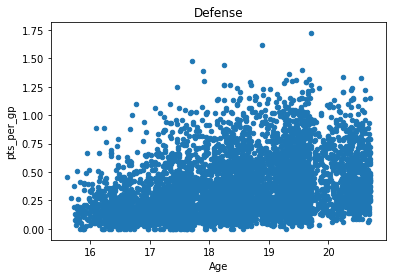

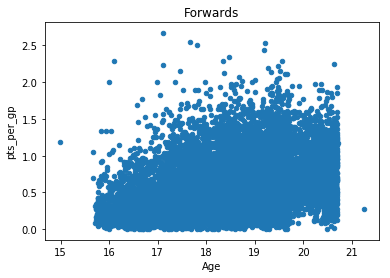

In [7]:
#graphing the correlation between age and points per game 
%matplotlib inline
import matplotlib.pyplot as plt
ax1 = age_adj_def_df.plot(kind='scatter', x='Age', y='pts_per_gp')
ax2 = age_adj_fwd_df.plot(kind='scatter', x='Age', y='pts_per_gp')
ax1.set_title('Defense')
ax2.set_title('Forwards')
print(ax1)
print(ax2)

In [8]:
#getting the coef and yint of the linear regression for points age adj.
def_adj_model = linear_model.LinearRegression()
def_adj_model.fit(age_adj_def_df[['Age']].values, age_adj_def_df['pts_per_gp'].values)
def_model_coef = round(def_adj_model.coef_[0], 3)

fwd_adj_model = linear_model.LinearRegression()
fwd_adj_model.fit(age_adj_fwd_df[['Age']].values, age_adj_fwd_df['pts_per_gp'].values)
fwd_model_coef = round(fwd_adj_model.coef_[0], 3)


/Users/MattBarlowe/.virtualenvs/prospectmodel/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [9]:
#creating adjusted pts per game for forwards and defense
age_adj_def_df['age_adj_pts_g'] = (1- ((age_adj_def_df['Age']-17) * def_model_coef)) \
                                        * age_adj_def_df['pts_per_gp']
age_adj_fwd_df['age_adj_pts_g'] = (1- ((age_adj_fwd_df['Age']-17) * fwd_model_coef)) \
                                        * age_adj_fwd_df['pts_per_gp']

#(1 - ([Age as of September of draft year - 17] * model_coef)) * Pts/GP as from Rhys Jessop formula

In [10]:
#concatting the Major Junior leagues fwds and def dataframes back together 
frames = [age_adj_def_df, age_adj_fwd_df]
age_adj_df = pd.concat(frames)
age_adj_df = age_adj_df.fillna(value=0)

roster = roster.merge(age_adj_df[['player_id', 'age_adj_pts_g']], on='player_id', how='left')
roster.age_adj_pts_g.fillna(inplace=True, value=roster['pts_per_gp'])

In [14]:
roster.columns


Index(['Player', 'Age', 'Position', 'Birthdate', 'HT', 'WT', 'season',
       'season_start', 'draft_cutoff', 'draft_cutoff_age', 'draft_year',
       'player_id', 'league', 'GP', 'G', 'A', 'TP', 'PIM', 'playoff_GP',
       'playoff_G', 'playoff_A', 'playoff_TP', 'playoff_PIM', 'playoff_+/-',
       'goals_to_points', 'assists_to_points', 'pts_per_gp', 'nhl_GP', 'nhl_G',
       'nhl_A', 'nhl_TP', 'nhl_pts_per_gp', 'NHLe_rates', 'NHLe_tp',
       'NHLe_ppg', 'age_adj_pts_g'],
      dtype='object')

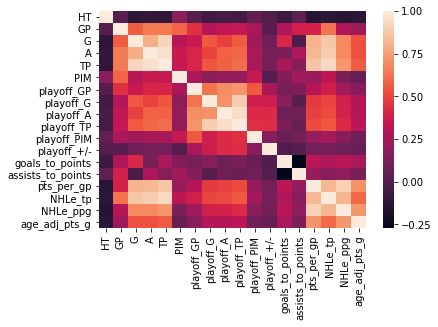

In [20]:
import seaborn as sns

sns.heatmap(roster[['HT', 'WT', 'GP', 'G', 'A', 'TP', 'PIM', 'playoff_GP', 'playoff_G', 'playoff_A', 
                    'playoff_TP', 'playoff_PIM', 'playoff_+/-', 'goals_to_points', 'assists_to_points',
                    'pts_per_gp', 'NHLe_tp', 'NHLe_ppg', 'age_adj_pts_g']].corr())

In [21]:
#Look at the correlation of variables to Games Played and total points
roster[['HT', 'WT', 'GP', 'G', 'A', 'TP', 'PIM', 'playoff_GP', 'playoff_G', 'playoff_A', 
        'playoff_TP', 'playoff_PIM', 'playoff_+/-', 'goals_to_points', 'assists_to_points',
        'pts_per_gp', 'NHLe_tp', 'NHLe_ppg', 'age_adj_pts_g', 'nhl_GP', 'nhl_TP', 'nhl_pts_per_gp']]\
.corr().reindex(['nhl_GP', 'nhl_TP', 'nhl_pts_per_gp'], index='columns').transpose()

,nhl_GP,nhl_TP,nhl_pts_per_gp
HT,0.092921,0.051379,0.075055
GP,0.041845,0.028631,0.059854
G,0.147853,0.158340,0.204519
A,0.162071,0.163919,0.217836
TP,0.164502,0.170212,0.223651
PIM,0.064449,0.036770,0.035343
playoff_GP,0.072313,0.066093,0.083354
playoff_G,0.126725,0.138776,0.170813
playoff_A,0.144732,0.152249,0.183009
playoff_TP,0.148089,0.158192,0.191917


In [ ]:
#turn the league variable into a series of dummy variables for each player 
roster = pd.get_dummies(roster, columns=['league'])

In [ ]:
#split roster into one for forwards and defensemen for model training and into
#one for just 2018 to look at model outputs 
draft_2018_df = roster[roster['season'] == 2018]
roster = roster[roster['season']<2018]
draft_df_fwd = roster[roster['Position'] != 'D']
draft_df_def = roster[roster['Position'] == 'D']
draft_2018_df_def = draft_2018_df[draft_2018_df['Position'] == 'D']
draft_2018_df_fwd = draft_2018_df[draft_2018_df['Position'] != 'D']

In [ ]:
#Determine Forward quartile buckets for GP and pts per game
draft_df_fwd[['GP', 'nhl_pts_per_gp']].quantile([.25, .5, .75, .95, .96, .97, .98, .99])

In [ ]:
#Determine Defense quartile buckets for GP and pts per game
#looks like just projecting for the 99th percentile may be the best 
#bet for both GP and points per game in order to find true NHLers
draft_df_def[['GP', 'nhl_pts_per_gp']].quantile([.25, .5, .75, .8, .94, .99])

In [ ]:
#setting up games played and points bins to run the seperate models on
draft_df_def['>_72_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=72), 1, 0)
draft_df_def['>_150_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=150), 1, 0)
draft_df_def['>_200_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=72), 1, 0)
draft_df_def['>_.18_nhl_pts_gp'] = np.where((draft_df_def['nhl_pts_per_gp'] >=.18), 1, 0)
draft_df_def['>_.25_nhl_pts_gp'] = np.where((draft_df_def['nhl_pts_per_gp'] >=.25), 1, 0)
draft_df_def['>_.47_nhl_pts_gp'] = np.where((draft_df_def['nhl_pts_per_gp'] >=.47), 1, 0)

#repeating process for forwards
draft_df_fwd['>_72_nhl_gp'] = np.where((draft_df_fwd['nhl_GP'] >=72), 1, 0)
draft_df_fwd['>_150_nhl_gp'] = np.where((draft_df_fwd['nhl_GP'] >=150), 1, 0)
draft_df_fwd['>_200_nhl_gp'] = np.where((draft_df_fwd['nhl_GP'] >=200), 1, 0)
draft_df_fwd['>_.30_nhl_pts_gp'] = np.where((draft_df_fwd['nhl_pts_per_gp'] >=.30), 1, 0)
draft_df_fwd['>_.42_nhl_pts_gp'] = np.where((draft_df_fwd['nhl_pts_per_gp'] >=.42), 1, 0)
draft_df_fwd['>_.68_nhl_pts_gp'] = np.where((draft_df_fwd['nhl_pts_per_gp'] >=.68), 1, 0)

In [ ]:
draft_df_fwd = draft_df_fwd.reset_index()
draft_df_def = draft_df_def.reset_index()

In [ ]:
features = ['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 'playoff_+/-',
            'goals_to_points', 'assists_to_points', 'age_adj_pts_g', 'league_Allsvenskan', 
            'league_Extraliga','league_KHL', 'league_Liiga', 'league_Mestis', 'league_NCAA', 'league_OHL', 
            'league_QMJHL', 'league_SHL', 'league_USHL', 'league_WHL','NHLe_ppg', 'NHLe_tp']

In [ ]:
#Splitting the data into 80/20 train test split with playing more than 72 games as the feature to predict 
#and greater than .25 points per game



X_train_def, X_test_def, \
y_train_def, y_test_def = train_test_split(draft_df_def[features],
                                                     draft_df_def[['>_72_nhl_gp', '>_150_nhl_gp','>_200_nhl_gp',
                                                                  '>_.18_nhl_pts_gp', '>_.25_nhl_pts_gp', 
                                                                  '>_.47_nhl_pts_gp']], 
                                                     test_size=0.2, random_state=SEED)




X_train_fwd, X_test_fwd, \
y_train_fwd, y_test_fwd = train_test_split(draft_df_fwd[features],
                                                     draft_df_fwd[['>_72_nhl_gp', '>_150_nhl_gp','>_200_nhl_gp',
                                                                  '>_.30_nhl_pts_gp', '>_.42_nhl_pts_gp', 
                                                                  '>_.68_nhl_pts_gp']], 
                                                     test_size=0.2, random_state=SEED)

In [ ]:
X_train_def = X_train_def.reset_index()
y_train_def = y_train_def.reset_index()
X_test_def = X_test_def.reset_index()
y_test_def = y_test_def.reset_index()

In [ ]:

log_reg = LogisticRegression(max_iter=15000, random_state=SEED)
tree = RandomForestClassifier(random_state=SEED, bootstrap=True, class_weight='balanced',
                              n_jobs=-1)
dt = DecisionTreeClassifier(random_state=SEED, class_weight='balanced')
gnb_clf_def_gp_1 = GaussianNB()
gnb_clf_def_gp_2 = GaussianNB()
gnb_clf_def_gp_3 = GaussianNB()
gnb_clf_def_pts_1 = GaussianNB()
gnb_clf_def_pts_2 = GaussianNB()
gnb_clf_def_pts_3 = GaussianNB()
gnb_clf_fwd_gp_1 = GaussianNB()
gnb_clf_fwd_gp_2 = GaussianNB()
gnb_clf_fwd_gp_3 = GaussianNB()
gnb_clf_fwd_pts_1 = GaussianNB()
gnb_clf_fwd_pts_2 = GaussianNB()
gnb_clf_fwd_pts_3 = GaussianNB()

log_clf_def_gp_1 = log_reg
log_clf_def_gp_2 = log_reg
log_clf_def_gp_3 = log_reg
log_clf_fwd_gp_1 = log_reg
log_clf_fwd_gp_2 = log_reg
log_clf_fwd_gp_3 = log_reg
log_clf_def_pts_1 = log_reg
log_clf_def_pts_2 = log_reg
log_clf_def_pts_3 = log_reg
log_clf_fwd_pts_1 = log_reg
log_clf_fwd_pts_2 = log_reg
log_clf_fwd_pts_3 = log_reg

tree_clf_def_gp_1 = tree
tree_clf_def_gp_2 = tree
tree_clf_def_gp_3 = tree
tree_clf_fwd_gp_1 = tree
tree_clf_fwd_gp_2 = tree
tree_clf_fwd_gp_3 = tree
tree_clf_def_pts_1 = tree
tree_clf_def_pts_2 = tree
tree_clf_def_pts_3 = tree
tree_clf_fwd_pts_1 = tree
tree_clf_fwd_pts_2 = tree
tree_clf_fwd_pts_3 = tree

dt_clf_def_gp_1 = dt
dt_clf_def_gp_2 = dt
dt_clf_def_gp_3 = dt
dt_clf_fwd_gp_1 = dt
dt_clf_fwd_gp_2 = dt
dt_clf_fwd_gp_3 = dt
dt_clf_def_pts_1 = dt
dt_clf_def_pts_2 = dt
dt_clf_def_pts_3 = dt
dt_clf_fwd_pts_1 = dt
dt_clf_fwd_pts_2 = dt
dt_clf_fwd_pts_3 = dt

In [ ]:
ntrain = X_train_def.shape[0]
ntest = X_test_def.shape[0]
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=5, random_state=SEED)

#need to convert y_train to a new dataframe first before indexing with kfold test train split
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train.iloc[train_index, :]
        y_tr = y_train.iloc[train_index, :]
        x_te = x_train.iloc[test_index, :]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [ ]:
gbm = XGBClassifier(objective = "binary:logistic", 
                    scale_pos_weight = 3,
                   eval_metric = "auc",    
                   eta = .068, 
                   gamma = .12,
                   subsample = .78, 
                   max_depth = 2,           
                   colsample_bytree = .76,  
                   min_child_weight = 5,   
                   max_delta_step = 5,      
                   nthread = 4)

In [ ]:
gbm_clf_def_gp_1 = gbm
gbm_clf_def_gp_2 = gbm
gbm_clf_def_gp_3 = gbm
gbm_clf_fwd_gp_1 = gbm
gbm_clf_fwd_gp_2 = gbm
gbm_clf_fwd_gp_3 = gbm
gbm_clf_def_pts_1 = gbm
gbm_clf_def_pts_2 = gbm
gbm_clf_def_pts_3 = gbm
gbm_clf_fwd_pts_1 = gbm
gbm_clf_fwd_pts_2 = gbm
gbm_clf_fwd_pts_3 = gbm

In [ ]:
#If you don't want to save the models you can skip pickling them and just run the training cells.
#train all the models
gbm_clf_def_gp_1.fit(X_train_def, y_train_def.loc[:, '>_72_nhl_gp'])
gbm_clf_def_gp_2.fit(X_train_def, y_train_def.loc[:, '>_150_nhl_gp'])
gbm_clf_def_gp_3.fit(X_train_def, y_train_def.loc[:, '>_200_nhl_gp'])
gbm_clf_def_pts_1.fit(X_train_def, y_train_def.loc[:, '>_.18_nhl_pts_gp'])
gbm_clf_def_pts_2.fit(X_train_def, y_train_def.loc[:, '>_.25_nhl_pts_gp'])
gbm_clf_def_pts_3.fit(X_train_def, y_train_def.loc[:, '>_.47_nhl_pts_gp'])
gbm_clf_fwd_gp_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_72_nhl_gp'])
gbm_clf_fwd_gp_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_150_nhl_gp'])
gbm_clf_fwd_gp_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_200_nhl_gp'])
gbm_clf_fwd_pts_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_.30_nhl_pts_gp'])
gbm_clf_fwd_pts_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_.42_nhl_pts_gp'])
gbm_clf_fwd_pts_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_.68_nhl_pts_gp'])

In [ ]:

#If you don't want to save the models you can skip pickling them and just run the training cells.
#train all the models
log_clf_def_gp_1.fit(X_train_def, y_train_def.loc[:, '>_72_nhl_gp'])
log_clf_def_gp_2.fit(X_train_def, y_train_def.loc[:, '>_150_nhl_gp'])
log_clf_def_gp_3.fit(X_train_def, y_train_def.loc[:, '>_200_nhl_gp'])
log_clf_def_pts_1.fit(X_train_def, y_train_def.loc[:, '>_.18_nhl_pts_gp'])
log_clf_def_pts_2.fit(X_train_def, y_train_def.loc[:, '>_.25_nhl_pts_gp'])
log_clf_def_pts_3.fit(X_train_def, y_train_def.loc[:, '>_.47_nhl_pts_gp'])
log_clf_fwd_gp_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_72_nhl_gp'])
log_clf_fwd_gp_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_150_nhl_gp'])
log_clf_fwd_gp_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_200_nhl_gp'])
log_clf_fwd_pts_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_.30_nhl_pts_gp'])
log_clf_fwd_pts_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_.42_nhl_pts_gp'])
log_clf_fwd_pts_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_.68_nhl_pts_gp'])
print('Logistic Regression Finished Training')


In [ ]:

gnb_clf_def_gp_1.fit(X_train_def, y_train_def.loc[:, '>_72_nhl_gp'])
gnb_clf_def_gp_2.fit(X_train_def, y_train_def.loc[:, '>_150_nhl_gp'])
gnb_clf_def_gp_3.fit(X_train_def, y_train_def.loc[:, '>_200_nhl_gp'])
gnb_clf_def_pts_1.fit(X_train_def, y_train_def.loc[:, '>_.18_nhl_pts_gp'])
gnb_clf_def_pts_2.fit(X_train_def, y_train_def.loc[:, '>_.25_nhl_pts_gp'])
gnb_clf_def_pts_3.fit(X_train_def, y_train_def.loc[:, '>_.47_nhl_pts_gp'])
gnb_clf_fwd_gp_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_72_nhl_gp'])
gnb_clf_fwd_gp_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_150_nhl_gp'])
gnb_clf_fwd_gp_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_200_nhl_gp'])
gnb_clf_fwd_pts_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_.30_nhl_pts_gp'])
gnb_clf_fwd_pts_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_.42_nhl_pts_gp'])
gnb_clf_fwd_pts_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_.68_nhl_pts_gp'])
print('GNB Finished Training')


In [ ]:

dt_clf_def_gp_1.fit(X_train_def, y_train_def.loc[:, '>_72_nhl_gp'])
dt_clf_def_gp_2.fit(X_train_def, y_train_def.loc[:, '>_150_nhl_gp'])
dt_clf_def_gp_3.fit(X_train_def, y_train_def.loc[:, '>_200_nhl_gp'])
dt_clf_def_pts_1.fit(X_train_def, y_train_def.loc[:, '>_.18_nhl_pts_gp'])
dt_clf_def_pts_2.fit(X_train_def, y_train_def.loc[:, '>_.25_nhl_pts_gp'])
dt_clf_def_pts_3.fit(X_train_def, y_train_def.loc[:, '>_.47_nhl_pts_gp'])
dt_clf_fwd_gp_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_72_nhl_gp'])
dt_clf_fwd_gp_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_150_nhl_gp'])
dt_clf_fwd_gp_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_200_nhl_gp'])
dt_clf_fwd_pts_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_.30_nhl_pts_gp'])
dt_clf_fwd_pts_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_.42_nhl_pts_gp'])
dt_clf_fwd_pts_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_.68_nhl_pts_gp'])
print('Decision Tree Finished Training')


In [ ]:

tree_clf_def_gp_1.fit(X_train_def, y_train_def.loc[:, '>_72_nhl_gp'])
tree_clf_def_gp_2.fit(X_train_def, y_train_def.loc[:, '>_150_nhl_gp'])
tree_clf_def_gp_3.fit(X_train_def, y_train_def.loc[:, '>_200_nhl_gp'])
tree_clf_def_pts_1.fit(X_train_def, y_train_def.loc[:, '>_.18_nhl_pts_gp'])
tree_clf_def_pts_2.fit(X_train_def, y_train_def.loc[:, '>_.25_nhl_pts_gp'])
tree_clf_def_pts_3.fit(X_train_def, y_train_def.loc[:, '>_.47_nhl_pts_gp'])
tree_clf_fwd_gp_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_72_nhl_gp'])
tree_clf_fwd_gp_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_150_nhl_gp'])
tree_clf_fwd_gp_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_200_nhl_gp'])
tree_clf_fwd_pts_1.fit(X_train_fwd, y_train_fwd.loc[:, '>_.30_nhl_pts_gp'])
tree_clf_fwd_pts_2.fit(X_train_fwd, y_train_fwd.loc[:, '>_.42_nhl_pts_gp'])
tree_clf_fwd_pts_3.fit(X_train_fwd, y_train_fwd.loc[:, '>_.68_nhl_pts_gp'])
print('Random Forest Finished Training')


In [ ]:
'''
#saving random forest models
with open(os.path.join('trained_models','tree_clf_def_gp_1'), 'wb') as f:
    pickle.dump(tree_clf_def_gp_1, f)

with open(os.path.join('trained_models','tree_clf_def_gp_2'), 'wb') as f:
    pickle.dump(tree_clf_def_gp_2, f)

with open(os.path.join('trained_models','tree_clf_def_gp_3'), 'wb') as f:
    pickle.dump(tree_clf_def_gp_3, f)
    
with open(os.path.join('trained_models','tree_clf_def_pts_1'), 'wb') as f:
    pickle.dump(tree_clf_def_pts_1, f)
    
with open(os.path.join('trained_models','tree_clf_def_pts_2'), 'wb') as f:
    pickle.dump(tree_clf_def_pts_2, f)
    
with open(os.path.join('trained_models','tree_clf_def_pts_3'), 'wb') as f:
    pickle.dump(tree_clf_def_pts_3, f)
    
with open(os.path.join('trained_models','tree_clf_fwd_gp_1'), 'wb') as f:
    pickle.dump(tree_clf_fwd_gp_1, f)

with open(os.path.join('trained_models','tree_clf_fwd_gp_2'), 'wb') as f:
    pickle.dump(tree_clf_fwd_gp_2, f)

with open(os.path.join('trained_models','tree_clf_fwd_gp_3'), 'wb') as f:
    pickle.dump(tree_clf_fwd_gp_3, f)
    
with open(os.path.join('trained_models','tree_clf_fwd_pts_1'), 'wb') as f:
    pickle.dump(tree_clf_fwd_pts_1, f)
    
with open(os.path.join('trained_models','tree_clf_fwd_pts_2'), 'wb') as f:
    pickle.dump(tree_clf_fwd_pts_2, f)
    
with open(os.path.join('trained_models','tree_clf_fwd_pts_3'), 'wb') as f:
    pickle.dump(tree_clf_fwd_pts_3, f)
'''

In [ ]:
'''
#saving gnb models
with open(os.path.join('trained_models','gnb_clf_def_gp_1'), 'wb') as f:
    pickle.dump(gnb_clf_def_gp_1, f)

with open(os.path.join('trained_models','gnb_clf_def_gp_2'), 'wb') as f:
    pickle.dump(gnb_clf_def_gp_2, f)

with open(os.path.join('trained_models','gnb_clf_def_gp_3'), 'wb') as f:
    pickle.dump(gnb_clf_def_gp_3, f)
    
with open(os.path.join('trained_models','gnb_clf_def_pts_1'), 'wb') as f:
    pickle.dump(gnb_clf_def_pts_1, f)
    
with open(os.path.join('trained_models','gnb_clf_def_pts_2'), 'wb') as f:
    pickle.dump(gnb_clf_def_pts_2, f)
    
with open(os.path.join('trained_models','gnb_clf_def_pts_3'), 'wb') as f:
    pickle.dump(gnb_clf_def_pts_3, f)
    
with open(os.path.join('trained_models','gnb_clf_fwd_gp_1'), 'wb') as f:
    pickle.dump(gnb_clf_fwd_gp_1, f)

with open(os.path.join('trained_models','gnb_clf_fwd_gp_2'), 'wb') as f:
    pickle.dump(gnb_clf_fwd_gp_2, f)

with open(os.path.join('trained_models','gnb_clf_fwd_gp_3'), 'wb') as f:
    pickle.dump(gnb_clf_fwd_gp_3, f)
    
with open(os.path.join('trained_models','gnb_clf_fwd_pts_1'), 'wb') as f:
    pickle.dump(gnb_clf_fwd_pts_1, f)
    
with open(os.path.join('trained_models','gnb_clf_fwd_pts_2'), 'wb') as f:
    pickle.dump(gnb_clf_fwd_pts_2, f)
    
with open(os.path.join('trained_models','gnb_clf_fwd_pts_3'), 'wb') as f:
    pickle.dump(gnb_clf_fwd_pts_3, f)
'''

In [ ]:
'''
#saving log regression models
with open(os.path.join('trained_models','log_clf_def_gp_1'), 'wb') as f:
    pickle.dump(log_clf_def_gp_1, f)

with open(os.path.join('trained_models','log_clf_def_gp_2'), 'wb') as f:
    pickle.dump(log_clf_def_gp_2, f)

with open(os.path.join('trained_models','log_clf_def_gp_3'), 'wb') as f:
    pickle.dump(log_clf_def_gp_3, f)
    
with open(os.path.join('trained_models','log_clf_def_pts_1'), 'wb') as f:
    pickle.dump(log_clf_def_pts_1, f)
    
with open(os.path.join('trained_models','log_clf_def_pts_2'), 'wb') as f:
    pickle.dump(log_clf_def_pts_2, f)
    
with open(os.path.join('trained_models','log_clf_def_pts_3'), 'wb') as f:
    pickle.dump(log_clf_def_pts_3, f)
    
with open(os.path.join('trained_models','log_clf_fwd_gp_1'), 'wb') as f:
    pickle.dump(log_clf_fwd_gp_1, f)

with open(os.path.join('trained_models','log_clf_fwd_gp_2'), 'wb') as f:
    pickle.dump(log_clf_fwd_gp_2, f)

with open(os.path.join('trained_models','log_clf_fwd_gp_3'), 'wb') as f:
    pickle.dump(log_clf_fwd_gp_3, f)
    
with open(os.path.join('trained_models','log_clf_fwd_pts_1'), 'wb') as f:
    pickle.dump(log_clf_fwd_pts_1, f)
    
with open(os.path.join('trained_models','log_clf_fwd_pts_2'), 'wb') as f:
    pickle.dump(log_clf_fwd_pts_2, f)
    
with open(os.path.join('trained_models','log_clf_fwd_pts_3'), 'wb') as f:
    pickle.dump(log_clf_fwd_pts_3, f)
'''

In [ ]:
'''
#saving decision tree models
with open(os.path.join('trained_models','dt_clf_def_gp_1'), 'wb') as f:
    pickle.dump(dt_clf_def_gp_1, f)

with open(os.path.join('trained_models','dt_clf_def_gp_2'), 'wb') as f:
    pickle.dump(dt_clf_def_gp_2, f)

with open(os.path.join('trained_models','dt_clf_def_gp_3'), 'wb') as f:
    pickle.dump(dt_clf_def_gp_3, f)
    
with open(os.path.join('trained_models','dt_clf_def_pts_1'), 'wb') as f:
    pickle.dump(dt_clf_def_pts_1, f)
    
with open(os.path.join('trained_models','dt_clf_def_pts_2'), 'wb') as f:
    pickle.dump(dt_clf_def_pts_2, f)
    
with open(os.path.join('trained_models','dt_clf_def_pts_3'), 'wb') as f:
    pickle.dump(dt_clf_def_pts_3, f)
    
with open(os.path.join('trained_models','dt_clf_fwd_gp_1'), 'wb') as f:
    pickle.dump(dt_clf_fwd_gp_1, f)

with open(os.path.join('trained_models','dt_clf_fwd_gp_2'), 'wb') as f:
    pickle.dump(dt_clf_fwd_gp_2, f)

with open(os.path.join('trained_models','dt_clf_fwd_gp_3'), 'wb') as f:
    pickle.dump(dt_clf_fwd_gp_3, f)
    
with open(os.path.join('trained_models','dt_clf_fwd_pts_1'), 'wb') as f:
    pickle.dump(dt_clf_fwd_pts_1, f)
    
with open(os.path.join('trained_models','dt_clf_fwd_pts_2'), 'wb') as f:
    pickle.dump(dt_clf_fwd_pts_2, f)
    
with open(os.path.join('trained_models','dt_clf_fwd_pts_3'), 'wb') as f:
    pickle.dump(dt_clf_fwd_pts_3, f)
'''

In [ ]:
#loading decision tree models
with open(os.path.join('trained_models','dt_clf_fwd_pts_1'), 'rb') as f:
    dt_clf_fwd_pts_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_fwd_pts_2'), 'rb') as f:
    dt_clf_fwd_pts_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_fwd_pts_3'), 'rb') as f:
    dt_clf_fwd_pts_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_fwd_gp_1'), 'rb') as f:
    dt_clf_fwd_gp_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_fwd_gp_2'), 'rb') as f:
    dt_clf_fwd_gp_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_fwd_gp_3'), 'rb') as f:
    dt_clf_fwd_gp_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_def_pts_1'), 'rb') as f:
    dt_clf_def_pts_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_def_pts_2'), 'rb') as f:
    dt_clf_def_pts_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_def_pts_3'), 'rb') as f:
    dt_clf_def_pts_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_def_gp_1'), 'rb') as f:
    dt_clf_def_gp_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_def_gp_2'), 'rb') as f:
    dt_clf_def_gp_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','dt_clf_def_gp_3'), 'rb') as f:
    dt_clf_def_gp_3 =  pickle.load(f)

In [ ]:
#load random forest models
with open(os.path.join('trained_models','tree_clf_fwd_pts_1'), 'rb') as f:
    tree_clf_fwd_pts_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_fwd_pts_2'), 'rb') as f:
    tree_clf_fwd_pts_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_fwd_pts_3'), 'rb') as f:
    tree_clf_fwd_pts_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_fwd_gp_1'), 'rb') as f:
    tree_clf_fwd_gp_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_fwd_gp_2'), 'rb') as f:
    tree_clf_fwd_gp_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_fwd_pts_3'), 'rb') as f:
    tree_clf_fwd_gp_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_def_pts_1'), 'rb') as f:
    tree_clf_def_pts_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_def_pts_2'), 'rb') as f:
    tree_clf_def_pts_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_def_pts_3'), 'rb') as f:
    tree_clf_def_pts_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_def_gp_1'), 'rb') as f:
    tree_clf_def_gp_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_def_gp_2'), 'rb') as f:
    tree_clf_def_gp_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','tree_clf_def_pts_3'), 'rb') as f:
    tree_clf_def_gp_3 =  pickle.load(f)

In [ ]:
#load GNB classifier
with open(os.path.join('trained_models','gnb_clf_fwd_pts_1'), 'rb') as f:
    gnb_clf_fwd_pts_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_fwd_pts_2'), 'rb') as f:
    gnb_clf_fwd_pts_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_fwd_pts_3'), 'rb') as f:
    gnb_clf_fwd_pts_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_fwd_gp_1'), 'rb') as f:
    gnb_clf_fwd_gp_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_fwd_gp_2'), 'rb') as f:
    gnb_clf_fwd_gp_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_fwd_pts_3'), 'rb') as f:
    gnb_clf_fwd_gp_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_def_pts_1'), 'rb') as f:
    gnb_clf_def_pts_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_def_pts_2'), 'rb') as f:
    gnb_clf_def_pts_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_def_pts_3'), 'rb') as f:
    gnb_clf_def_pts_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_def_gp_1'), 'rb') as f:
    gnb_clf_def_gp_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_def_gp_2'), 'rb') as f:
    gnb_clf_def_gp_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','gnb_clf_def_pts_3'), 'rb') as f:
    gnb_clf_def_gp_3 =  pickle.load(f)

In [ ]:
#loading log regression classifier
with open(os.path.join('trained_models','log_clf_fwd_pts_1'), 'rb') as f:
    log_clf_fwd_pts_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_fwd_pts_2'), 'rb') as f:
    log_clf_fwd_pts_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_fwd_pts_3'), 'rb') as f:
    log_clf_fwd_pts_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_fwd_gp_1'), 'rb') as f:
    log_clf_fwd_gp_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_fwd_gp_2'), 'rb') as f:
    log_clf_fwd_gp_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_fwd_pts_3'), 'rb') as f:
    log_clf_fwd_gp_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_def_pts_1'), 'rb') as f:
    log_clf_def_pts_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_def_pts_2'), 'rb') as f:
    log_clf_def_pts_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_def_pts_3'), 'rb') as f:
    log_clf_def_pts_3 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_def_gp_1'), 'rb') as f:
    log_clf_def_gp_1 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_def_gp_2'), 'rb') as f:
    log_clf_def_gp_2 =  pickle.load(f)
    
with open(os.path.join('trained_models','log_clf_def_pts_3'), 'rb') as f:
    log_clf_def_gp_3 =  pickle.load(f)

In [ ]:
#setting up games played and points bins to run the seperate models on
draft_df_def['>_72_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=72), 1, 0)
draft_df_def['>_150_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=150), 1, 0)
draft_df_def['>_200_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=72), 1, 0)
draft_df_def['>_.18_nhl_pts_gp'] = np.where((draft_df_def['nhl_pts_per_gp'] >=.18), 1, 0)
draft_df_def['>_.25_nhl_pts_gp'] = np.where((draft_df_def['nhl_pts_per_gp'] >=.25), 1, 0)
draft_df_def['>_.47_nhl_pts_gp'] = np.where((draft_df_def['nhl_pts_per_gp'] >=.47), 1, 0)

#repeating process for forwards
draft_df_fwd['>_72_nhl_gp'] = np.where((draft_df_fwd['nhl_GP'] >=72), 1, 0)
draft_df_fwd['>_150_nhl_gp'] = np.where((draft_df_fwd['nhl_GP'] >=150), 1, 0)
draft_df_fwd['>_200_nhl_gp'] = np.where((draft_df_fwd['nhl_GP'] >=200), 1, 0)
draft_df_fwd['>_.30_nhl_pts_gp'] = np.where((draft_df_fwd['nhl_pts_per_gp'] >=.30), 1, 0)
draft_df_fwd['>_.42_nhl_pts_gp'] = np.where((draft_df_fwd['nhl_pts_per_gp'] >=.42), 1, 0)
draft_df_fwd['>_.68_nhl_pts_gp'] = np.where((draft_df_fwd['nhl_pts_per_gp'] >=.68), 1, 0)

In [ ]:
#predicting random forest results on train data
draft_df_def['prob_tree_>_.18_ppg'] = tree_clf_def_pts_1.predict_proba(draft_df_def[features])[:, 1]
draft_df_def['prob_tree_>_.25_ppg'] = tree_clf_def_pts_2.predict_proba(draft_df_def[features])[:, 1]
draft_df_def['prob_tree_>_.47_ppg'] = tree_clf_def_pts_3.predict_proba(draft_df_def[features])[:, 1]
draft_df_fwd['prob_tree_>_.30_ppg'] = tree_clf_fwd_pts_1.predict_proba(draft_df_fwd[features])[:, 1]
draft_df_fwd['prob_tree_>_.42_ppg'] = tree_clf_fwd_pts_2.predict_proba(draft_df_fwd[features])[:, 1]
draft_df_fwd['prob_tree_>_.68_ppg'] = tree_clf_fwd_pts_3.predict_proba(draft_df_fwd[features])[:, 1]
draft_df_def['prob_tree_>_72_gp'] = tree_clf_def_gp_1.predict_proba(draft_df_def[features])[:, 1]
draft_df_def['prob_tree_>_150_gp'] = tree_clf_def_gp_2.predict_proba(draft_df_def[features])[:, 1]
draft_df_def['prob_tree_>_200_gp'] = tree_clf_def_gp_3.predict_proba(draft_df_def[features])[:, 1]
draft_df_fwd['prob_tree_>_72_gp'] = tree_clf_fwd_gp_1.predict_proba(draft_df_fwd[features])[:, 1]
draft_df_fwd['prob_tree_>_150_gp'] = tree_clf_fwd_gp_2.predict_proba(draft_df_fwd[features])[:, 1]
draft_df_fwd['prob_tree_>_200_gp'] = tree_clf_fwd_gp_3.predict_proba(draft_df_fwd[features])[:, 1]

In [ ]:
#predicting random forest results on train data
draft_df_def['prob_log_>_.18_ppg'] = log_clf_def_pts_1.predict_proba(draft_df_def[features])[:, 1]
draft_df_def['prob_log_>_.25_ppg'] = log_clf_def_pts_2.predict_proba(draft_df_def[features])[:, 1]
draft_df_def['prob_log_>_.47_ppg'] = log_clf_def_pts_3.predict_proba(draft_df_def[features])[:, 1]
draft_df_fwd['prob_log_>_.30_ppg'] = log_clf_fwd_pts_1.predict_proba(draft_df_fwd[features])[:, 1]
draft_df_fwd['prob_log_>_.42_ppg'] = log_clf_fwd_pts_2.predict_proba(draft_df_fwd[features])[:, 1]
draft_df_fwd['prob_log_>_.68_ppg'] = log_clf_fwd_pts_3.predict_proba(draft_df_fwd[features])[:, 1]
draft_df_def['prob_log_>_72_gp'] = log_clf_def_gp_1.predict_proba(draft_df_def[features])[:, 1]
draft_df_def['prob_log_>_150_gp'] = log_clf_def_gp_2.predict_proba(draft_df_def[features])[:, 1]
draft_df_def['prob_log_>_200_gp'] = log_clf_def_gp_3.predict_proba(draft_df_def[features])[:, 1]
draft_df_fwd['prob_log_>_72_gp'] = log_clf_fwd_gp_1.predict_proba(draft_df_fwd[features])[:, 1]
draft_df_fwd['prob_log_>_150_gp'] = log_clf_fwd_gp_2.predict_proba(draft_df_fwd[features])[:, 1]
draft_df_fwd['prob_log_>_200_gp'] = log_clf_fwd_gp_3.predict_proba(draft_df_fwd[features])[:, 1]

In [ ]:
#predicting random forest results on train data
draft_df_def['prob_dt_>_.18_ppg'] = dt_clf_def_pts_1.predict_proba(draft_df_def[features])[:, 1]
draft_df_def['prob_dt_>_.25_ppg'] = dt_clf_def_pts_2.predict_proba(draft_df_def[features])[:, 1]
draft_df_def['prob_dt_>_.47_ppg'] = dt_clf_def_pts_3.predict_proba(draft_df_def[features])[:, 1]
draft_df_fwd['prob_dt_>_.30_ppg'] = dt_clf_fwd_pts_1.predict_proba(draft_df_fwd[features])[:, 1]
draft_df_fwd['prob_dt_>_.42_ppg'] = dt_clf_fwd_pts_2.predict_proba(draft_df_fwd[features])[:, 1]
draft_df_fwd['prob_dt_>_.68_ppg'] = dt_clf_fwd_pts_3.predict_proba(draft_df_fwd[features])[:, 1]
draft_df_def['prob_dt_>_72_gp'] = dt_clf_def_gp_1.predict_proba(draft_df_def[features])[:, 1]
draft_df_def['prob_dt_>_150_gp'] = dt_clf_def_gp_2.predict_proba(draft_df_def[features])[:, 1]
draft_df_def['prob_dt_>_200_gp'] = dt_clf_def_gp_3.predict_proba(draft_df_def[features])[:, 1]
draft_df_fwd['prob_dt_>_72_gp'] = dt_clf_fwd_gp_1.predict_proba(draft_df_fwd[features])[:, 1]
draft_df_fwd['prob_dt_>_150_gp'] = dt_clf_fwd_gp_2.predict_proba(draft_df_fwd[features])[:, 1]
draft_df_fwd['prob_dt_>_200_gp'] = dt_clf_fwd_gp_3.predict_proba(draft_df_fwd[features])[:, 1]

In [ ]:
#predicting random forest results on train data
draft_df_def['prob_gnb_>_.18_ppg'] = gnb_clf_def_pts_1.predict_proba(draft_df_def[features])[:, 1]
draft_df_def['prob_gnb_>_.25_ppg'] = gnb_clf_def_pts_2.predict_proba(draft_df_def[features])[:, 1]
draft_df_def['prob_gnb_>_.47_ppg'] = gnb_clf_def_pts_3.predict_proba(draft_df_def[features])[:, 1]
draft_df_fwd['prob_gnb_>_.30_ppg'] = gnb_clf_fwd_pts_1.predict_proba(draft_df_fwd[features])[:, 1]
draft_df_fwd['prob_gnb_>_.42_ppg'] = gnb_clf_fwd_pts_2.predict_proba(draft_df_fwd[features])[:, 1]
draft_df_fwd['prob_gnb_>_.68_ppg'] = gnb_clf_fwd_pts_3.predict_proba(draft_df_fwd[features])[:, 1]
draft_df_def['prob_gnb_>_72_gp'] = gnb_clf_def_gp_1.predict_proba(draft_df_def[features])[:, 1]
draft_df_def['prob_gnb_>_150_gp'] = gnb_clf_def_gp_2.predict_proba(draft_df_def[features])[:, 1]
draft_df_def['prob_gnb_>_200_gp'] = gnb_clf_def_gp_3.predict_proba(draft_df_def[features])[:, 1]
draft_df_fwd['prob_gnb_>_72_gp'] = gnb_clf_fwd_gp_1.predict_proba(draft_df_fwd[features])[:, 1]
draft_df_fwd['prob_gnb_>_150_gp'] = gnb_clf_fwd_gp_2.predict_proba(draft_df_fwd[features])[:, 1]
draft_df_fwd['prob_gnb_>_200_gp'] = gnb_clf_fwd_gp_3.predict_proba(draft_df_fwd[features])[:, 1]

In [ ]:
#predicting random forest results on train data
draft_2018_df_def['prob_tree_>_.18_ppg'] = tree_clf_def_pts_1.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_def['prob_tree_>_.25_ppg'] = tree_clf_def_pts_2.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_def['prob_tree_>_.47_ppg'] = tree_clf_def_pts_3.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_fwd['prob_tree_>_.30_ppg'] = tree_clf_fwd_pts_1.predict_proba(draft_2018_df_fwd[features])[:, 1]
draft_2018_df_fwd['prob_tree_>_.42_ppg'] = tree_clf_fwd_pts_2.predict_proba(draft_2018_df_fwd[features])[:, 1]
draft_2018_df_fwd['prob_tree_>_.68_ppg'] = tree_clf_fwd_pts_3.predict_proba(draft_2018_df_fwd[features])[:, 1]
draft_2018_df_def['prob_tree_>_72_gp'] = tree_clf_def_gp_1.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_def['prob_tree_>_150_gp'] = tree_clf_def_gp_2.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_def['prob_tree_>_200_gp'] = tree_clf_def_gp_3.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_fwd['prob_tree_>_72_gp'] = tree_clf_fwd_gp_1.predict_proba(draft_2018_df_fwd[features])[:, 1]
draft_2018_df_fwd['prob_tree_>_150_gp'] = tree_clf_fwd_gp_2.predict_proba(draft_2018_df_fwd[features])[:, 1]
draft_2018_df_fwd['prob_tree_>_200_gp'] = tree_clf_fwd_gp_3.predict_proba(draft_2018_df_fwd[features])[:, 1]



In [ ]:
#predicting random forest results on train data
draft_2018_df_def['prob_dt_>_.18_ppg'] = dt_clf_def_pts_1.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_def['prob_dt_>_.25_ppg'] = dt_clf_def_pts_2.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_def['prob_dt_>_.47_ppg'] = dt_clf_def_pts_3.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_fwd['prob_dt_>_.30_ppg'] = dt_clf_fwd_pts_1.predict_proba(draft_2018_df_fwd[features])[:, 1]
draft_2018_df_fwd['prob_dt_>_.42_ppg'] = dt_clf_fwd_pts_2.predict_proba(draft_2018_df_fwd[features])[:, 1]
draft_2018_df_fwd['prob_dt_>_.68_ppg'] = dt_clf_fwd_pts_3.predict_proba(draft_2018_df_fwd[features])[:, 1]
draft_2018_df_def['prob_dt_>_72_gp'] = dt_clf_def_gp_1.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_def['prob_dt_>_150_gp'] = dt_clf_def_gp_2.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_def['prob_dt_>_200_gp'] = dt_clf_def_gp_3.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_fwd['prob_dt_>_72_gp'] = dt_clf_fwd_gp_1.predict_proba(draft_2018_df_fwd[features])[:, 1]
draft_2018_df_fwd['prob_dt_>_150_gp'] = dt_clf_fwd_gp_2.predict_proba(draft_2018_df_fwd[features])[:, 1]
draft_2018_df_fwd['prob_dt_>_200_gp'] = dt_clf_fwd_gp_3.predict_proba(draft_2018_df_fwd[features])[:, 1]

In [ ]:
#predicting random forest results on train data
draft_2018_df_def['prob_log_>_.18_ppg'] = log_clf_def_pts_1.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_def['prob_log_>_.25_ppg'] = log_clf_def_pts_2.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_def['prob_log_>_.47_ppg'] = log_clf_def_pts_3.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_fwd['prob_log_>_.30_ppg'] = log_clf_fwd_pts_1.predict_proba(draft_2018_df_fwd[features])[:, 1]
draft_2018_df_fwd['prob_log_>_.42_ppg'] = log_clf_fwd_pts_2.predict_proba(draft_2018_df_fwd[features])[:, 1]
draft_2018_df_fwd['prob_log_>_.68_ppg'] = log_clf_fwd_pts_3.predict_proba(draft_2018_df_fwd[features])[:, 1]
draft_2018_df_def['prob_log_>_72_gp'] = log_clf_def_gp_1.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_def['prob_log_>_150_gp'] = log_clf_def_gp_2.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_def['prob_log_>_200_gp'] = log_clf_def_gp_3.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_fwd['prob_log_>_72_gp'] = log_clf_fwd_gp_1.predict_proba(draft_2018_df_fwd[features])[:, 1]
draft_2018_df_fwd['prob_log_>_150_gp'] = log_clf_fwd_gp_2.predict_proba(draft_2018_df_fwd[features])[:, 1]
draft_2018_df_fwd['prob_log_>_200_gp'] = log_clf_fwd_gp_3.predict_proba(draft_2018_df_fwd[features])[:, 1]

In [ ]:
#predicting random forest results on train data
draft_2018_df_def['prob_gnb_>_.18_ppg'] = gnb_clf_def_pts_1.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_def['prob_gnb_>_.25_ppg'] = gnb_clf_def_pts_2.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_def['prob_gnb_>_.47_ppg'] = gnb_clf_def_pts_3.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_fwd['prob_gnb_>_.30_ppg'] = gnb_clf_fwd_pts_1.predict_proba(draft_2018_df_fwd[features])[:, 1]
draft_2018_df_fwd['prob_gnb_>_.42_ppg'] = gnb_clf_fwd_pts_2.predict_proba(draft_2018_df_fwd[features])[:, 1]
draft_2018_df_fwd['prob_gnb_>_.68_ppg'] = gnb_clf_fwd_pts_3.predict_proba(draft_2018_df_fwd[features])[:, 1]
draft_2018_df_def['prob_gnb_>_72_gp'] = gnb_clf_def_gp_1.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_def['prob_gnb_>_150_gp'] = gnb_clf_def_gp_2.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_def['prob_gnb_>_200_gp'] = gnb_clf_def_gp_3.predict_proba(draft_2018_df_def[features])[:, 1]
draft_2018_df_fwd['prob_gnb_>_72_gp'] = gnb_clf_fwd_gp_1.predict_proba(draft_2018_df_fwd[features])[:, 1]
draft_2018_df_fwd['prob_gnb_>_150_gp'] = gnb_clf_fwd_gp_2.predict_proba(draft_2018_df_fwd[features])[:, 1]
draft_2018_df_fwd['prob_gnb_>_200_gp'] = gnb_clf_fwd_gp_3.predict_proba(draft_2018_df_fwd[features])[:, 1]

In [ ]:
draft_df_def['prob_>_72_gp'] = draft_df_def[['prob_gnb_>_72_gp','prob_tree_>_72_gp',
                                             'prob_dt_>_72_gp', 'prob_gnb_>_72_gp']].mean(axis=1)
draft_df_def['prob_>_150_gp'] = draft_df_def[['prob_gnb_>_150_gp','prob_tree_>_150_gp',
                                             'prob_dt_>_150_gp', 'prob_gnb_>_150_gp']].mean(axis=1)

draft_df_def['prob_>_200_gp'] = draft_df_def[['prob_gnb_>_200_gp','prob_tree_>_200_gp',
                                             'prob_dt_>_200_gp', 'prob_gnb_>_200_gp']].mean(axis=1)
draft_df_def['prob_>_.18_ppg'] = draft_df_def[['prob_gnb_>_.18_ppg','prob_tree_>_.18_ppg',
                                             'prob_dt_>_.18_ppg', 'prob_gnb_>_.18_ppg']].mean(axis=1)
draft_df_def['prob_>_.25_ppg'] = draft_df_def[['prob_gnb_>_.25_ppg','prob_tree_>_.25_ppg',
                                             'prob_dt_>_.25_ppg', 'prob_gnb_>_.25_ppg']].mean(axis=1)
draft_df_def['prob_>_.47_ppg'] = draft_df_def[['prob_gnb_>_.47_ppg','prob_tree_>_.47_ppg',
                                             'prob_dt_>_.47_ppg', 'prob_gnb_>_.47_ppg']].mean(axis=1)
draft_df_fwd['prob_>_72_gp'] = draft_df_fwd[['prob_gnb_>_72_gp','prob_tree_>_72_gp',
                                             'prob_dt_>_72_gp', 'prob_gnb_>_72_gp']].mean(axis=1)
draft_df_fwd['prob_>_150_gp'] = draft_df_fwd[['prob_gnb_>_150_gp','prob_tree_>_150_gp',
                                             'prob_dt_>_150_gp', 'prob_gnb_>_150_gp']].mean(axis=1)

draft_df_fwd['prob_>_200_gp'] = draft_df_fwd[['prob_gnb_>_200_gp','prob_tree_>_200_gp',
                                             'prob_dt_>_200_gp', 'prob_gnb_>_200_gp']].mean(axis=1)
draft_df_fwd['prob_>_.30_ppg'] = draft_df_fwd[['prob_gnb_>_.30_ppg','prob_tree_>_.30_ppg',
                                             'prob_dt_>_.30_ppg', 'prob_gnb_>_.30_ppg']].mean(axis=1)
draft_df_fwd['prob_>_.42_ppg'] = draft_df_fwd[['prob_gnb_>_.42_ppg','prob_tree_>_.42_ppg',
                                             'prob_dt_>_.42_ppg', 'prob_gnb_>_.42_ppg']].mean(axis=1)
draft_df_fwd['prob_>_.68_ppg'] = draft_df_fwd[['prob_gnb_>_.68_ppg','prob_tree_>_.68_ppg',
                                             'prob_dt_>_.68_ppg', 'prob_gnb_>_.68_ppg']].mean(axis=1)

In [ ]:
draft_2018_df_def['prob_>_72_gp'] = draft_2018_df_def[['prob_gnb_>_72_gp','prob_tree_>_72_gp',
                                                  'prob_dt_>_72_gp', 'prob_gnb_>_72_gp']].mean(axis=1)
draft_2018_df_def['prob_>_150_gp'] = draft_2018_df_def[['prob_gnb_>_150_gp','prob_tree_>_150_gp',
                                                   'prob_dt_>_150_gp', 'prob_gnb_>_150_gp']].mean(axis=1)

draft_2018_df_def['prob_>_200_gp'] = draft_2018_df_def[['prob_gnb_>_200_gp','prob_tree_>_200_gp',
                                                   'prob_dt_>_200_gp', 'prob_gnb_>_200_gp']].mean(axis=1)
draft_2018_df_def['prob_>_.18_ppg'] = draft_2018_df_def[['prob_gnb_>_.18_ppg','prob_tree_>_.18_ppg',
                                                    'prob_dt_>_.18_ppg', 'prob_gnb_>_.18_ppg']].mean(axis=1)
draft_2018_df_def['prob_>_.25_ppg'] = draft_2018_df_def[['prob_gnb_>_.25_ppg','prob_tree_>_.25_ppg',
                                                    'prob_dt_>_.25_ppg', 'prob_gnb_>_.25_ppg']].mean(axis=1)
draft_2018_df_def['prob_>_.47_ppg'] = draft_2018_df_def[['prob_gnb_>_.47_ppg','prob_tree_>_.47_ppg',
                                                    'prob_dt_>_.47_ppg', 'prob_gnb_>_.47_ppg']].mean(axis=1)
draft_2018_df_fwd['prob_>_72_gp'] = draft_2018_df_fwd[['prob_gnb_>_72_gp','prob_tree_>_72_gp',
                                                  'prob_dt_>_72_gp', 'prob_gnb_>_72_gp']].mean(axis=1)
draft_2018_df_fwd['prob_>_150_gp'] = draft_2018_df_fwd[['prob_gnb_>_150_gp','prob_tree_>_150_gp',
                                                   'prob_dt_>_150_gp', 'prob_gnb_>_150_gp']].mean(axis=1)

draft_2018_df_fwd['prob_>_200_gp'] = draft_2018_df_fwd[['prob_gnb_>_200_gp','prob_tree_>_200_gp',
                                                   'prob_dt_>_200_gp', 'prob_gnb_>_200_gp']].mean(axis=1)
draft_2018_df_fwd['prob_>_.30_ppg'] = draft_2018_df_fwd[['prob_gnb_>_.30_ppg','prob_tree_>_.30_ppg',
                                                    'prob_dt_>_.30_ppg', 'prob_gnb_>_.30_ppg']].mean(axis=1)
draft_2018_df_fwd['prob_>_.42_ppg'] = draft_2018_df_fwd[['prob_gnb_>_.42_ppg','prob_tree_>_.42_ppg',
                                                    'prob_dt_>_.42_ppg', 'prob_gnb_>_.42_ppg']].mean(axis=1)
draft_2018_df_fwd['prob_>_.68_ppg'] = draft_2018_df_fwd[['prob_gnb_>_.68_ppg','prob_tree_>_.68_ppg',
                                                    'prob_dt_>_.68_ppg', 'prob_gnb_>_.68_ppg']].mean(axis=1)

In [ ]:
from sklearn.linear_model import LinearRegression

linreg_def_gp = LinearRegression()
linreg_def_ppg = LinearRegression()
linreg_fwd_gp = LinearRegression()
linreg_fwd_ppg = LinearRegression()


In [ ]:
linreg_def_gp.fit(draft_df_def[['prob_>_72_gp', 'prob_>_150_gp', 'prob_>_200_gp']], draft_df_def[['nhl_GP']])
linreg_fwd_gp.fit(draft_df_fwd[['prob_>_72_gp', 'prob_>_150_gp', 'prob_>_200_gp']], draft_df_fwd[['nhl_GP']])

In [ ]:
linreg_def_ppg.fit(draft_df_def[['prob_>_.18_ppg', 'prob_>_.25_ppg', 'prob_>_.47_ppg']], draft_df_def[['nhl_pts_per_gp']])
linreg_fwd_ppg.fit(draft_df_fwd[['prob_>_.30_ppg', 'prob_>_.42_ppg', 'prob_>_.68_ppg']], draft_df_fwd[['nhl_pts_per_gp']])




In [ ]:
linreg_def_ppg.coef_

In [ ]:
linreg_fwd_ppg.coef_

In [ ]:
linreg_def_gp.coef_

In [ ]:
linreg_fwd_gp.coef_

In [ ]:
draft_2018_df_def['gp_prob'] = (112.79 *draft_2018_df_def['prob_>_72_gp'] + 
                                84.57*draft_2018_df_def['prob_>_150_gp'] +  
                                29.96*draft_2018_df_def['prob_>_150_gp'])/(112.79+84.57+29.96)

In [ ]:
draft_2018_df_fwd['gp_prob'] = (19.73 *draft_2018_df_fwd['prob_>_72_gp'] + 
                                208.27*draft_2018_df_fwd['prob_>_150_gp'] + 
                                39.42*draft_2018_df_fwd['prob_>_150_gp'])/(19.73+208.27+39.42)

In [ ]:
draft_2018_df_def['pts_prob'] = ( .063 *draft_2018_df_def['prob_>_.18_ppg'] + 
                                .075 * draft_2018_df_def['prob_>_.25_ppg'] + 
                                 .06*draft_2018_df_def['prob_>_.47_ppg'])/(.063+.075+.06)

In [ ]:
draft_2018_df_fwd['pts_prob'] = (.013* draft_2018_df_fwd['prob_>_.30_ppg'] + 
                                .28*draft_2018_df_fwd['prob_>_.42_ppg'] + 
                                 .056*draft_2018_df_fwd['prob_>_.68_ppg'])/(.013 + .28 + .056)

In [ ]:
draft_df_def['gp_prob'] = (112.79 *draft_df_def['prob_>_72_gp'] + 
                                84.57*draft_df_def['prob_>_150_gp'] +  
                                29.96*draft_df_def['prob_>_150_gp'])/(112.79+84.57+29.96)

In [ ]:
draft_df_fwd['gp_prob'] = (19.73 *draft_df_fwd['prob_>_72_gp'] + 
                                208.27*draft_df_fwd['prob_>_150_gp'] + 
                                39.42*draft_df_fwd['prob_>_150_gp'])/(19.73+208.27+39.42)

In [ ]:
draft_df_def['pts_prob'] = ( .063 *draft_df_def['prob_>_.18_ppg'] + 
                                .075 * draft_df_def['prob_>_.25_ppg'] + 
                                 .06*draft_df_def['prob_>_.47_ppg'])/(.063+.075+.06)

In [ ]:
draft_df_fwd['pts_prob'] = (.013* draft_df_fwd['prob_>_.30_ppg'] + 
                                .28*draft_df_fwd['prob_>_.42_ppg'] + 
                                 .056*draft_df_fwd['prob_>_.68_ppg'])/(.013 + .28 + .056)

In [ ]:
#draft_2018_df_def['pts_std_score'] = (draft_2018_df_def['pts_prob']- draft_2018_df_def['pts_prob'].mean())/draft_2018_df_def['pts_prob'].std()

draft_2018_df_def['draft_score'] = (draft_2018_df_def['pts_prob'] + draft_2018_df_def['gp_prob'])


In [ ]:
#draft_2018_df_fwd['gp_std_score'] = (draft_2018_df_fwd['gp_prob']- draft_2018_df_fwd['gp_prob'].mean())/draft_2018_df_fwd['gp_prob'].std()
#draft_2018_df_fwd['pts_std_score'] = (draft_2018_df_fwd['pts_prob']- draft_2018_df_fwd['pts_prob'].mean())/draft_2018_df_fwd['pts_prob'].std()

draft_2018_df_fwd['draft_score'] = (draft_2018_df_fwd['pts_prob'] + draft_2018_df_fwd['gp_prob'])

In [ ]:
draft_df_def['draft_score'] = draft_df_def['pts_prob'] + draft_df_def['gp_prob']
draft_df_fwd['draft_score'] = draft_df_fwd['pts_prob'] + draft_df_fwd['gp_prob']

In [ ]:
draft_df_def[['gp_prob', 'pts_prob', 'nhl_GP', 'nhl_pts_per_gp']].corr()

In [ ]:
draft_df = [draft_df_def[['Player', 'Position', 'draft_score', 'season']], 
            draft_df_fwd[['Player', 'Position', 'draft_score', 'season']]]
draft_df_score = pd.concat(draft_df)

In [ ]:
draft_2018 = [draft_2018_df_def[['Player', 'Position', 'draft_score']], 
              draft_2018_df_fwd[['Player', 'Position', 'draft_score']]]

draft_2018_df_score = pd.concat(draft_2018)

In [ ]:
draft_df_score=draft_df_score.groupby(['Player', 'Position', 'season'], 
                                      as_index=False).max().sort_values(['draft_score'], ascending=False)

In [ ]:
draft_2018_df_score=draft_2018_df_score.groupby(['Player', 'Position'], as_index=False).max().sort_values(['draft_score'], ascending=False)

In [ ]:
draft_2018_df_score = draft_2018_df_score.reset_index(drop=True)
draft_2018_df_score.index = np.arange(1,len(draft_2018_df_score)+1)

In [ ]:
draft_df_score = draft_df_score.reset_index(drop=True)
draft_df_score.index = np.arange(1,len(draft_df_score)+1)

In [ ]:
draft_df_fwd[draft_df_fwd['Player']=='Rob Schremp']

In [ ]:
draft_2018_df_score[draft_2018_df_score['Player'] == 'Martin Kaut']

In [ ]:
draft_df_score.to_csv('draft_score_hist.csv')

In [ ]:
draft_2018_df_score[draft_2018_df_score['Position']=='D'].head(20)

In [ ]:
draft_2018_df_score[draft_2018_df_score['Position']!='D'].head(20)

In [ ]:
#creating train dependent sets on which to train the xgboost model for points model
train_def_pts_1 = np.concatenate((train_gnb_def_pts_1.reshape(-1,1), train_dt_def_pts_1.reshape(-1,1), 
                            train_tree_def_pts_1.reshape(-1,1), train_log_def_pts_1.reshape(-1,1)), axis=1)

train_def_pts_2 = np.concatenate((train_gnb_def_pts_2.reshape(-1,1), train_dt_def_pts_2.reshape(-1,1), 
                            train_tree_def_pts_2.reshape(-1,1), train_log_def_pts_2.reshape(-1,1)), axis=1)

train_def_pts_3 = np.concatenate((train_gnb_def_pts_3.reshape(-1,1), train_dt_def_pts_3.reshape(-1,1), 
                            train_tree_def_pts_3.reshape(-1,1), train_log_def_pts_3.reshape(-1,1)), axis=1)

train_fwd_pts_1 = np.concatenate((train_gnb_fwd_pts_1.reshape(-1,1), train_dt_fwd_pts_1.reshape(-1,1), 
                            train_tree_fwd_pts_1.reshape(-1,1), train_log_fwd_pts_1.reshape(-1,1)), axis=1)

train_fwd_pts_2 = np.concatenate((train_gnb_fwd_pts_2.reshape(-1,1), train_dt_fwd_pts_2.reshape(-1,1), 
                            train_tree_fwd_pts_2.reshape(-1,1), train_log_fwd_pts_2.reshape(-1,1)), axis=1)

train_fwd_pts_3 = np.concatenate((train_gnb_fwd_pts_3.reshape(-1,1), train_dt_fwd_pts_3.reshape(-1,1), 
                            train_tree_fwd_pts_3.reshape(-1,1), train_log_fwd_pts_3.reshape(-1,1)), axis=1)

In [ ]:
#creating train dependent sets on which to test the xgboost games played models
train_def_gp_1 = np.concatenate((train_gnb_def_gp_1.reshape(-1,1), train_dt_def_gp_1.reshape(-1,1), 
                            train_tree_def_gp_1.reshape(-1,1), train_log_def_gp_1.reshape(-1,1)), axis=1)

train_def_gp_2 = np.concatenate((train_gnb_def_gp_2.reshape(-1,1), train_dt_def_gp_2.reshape(-1,1), 
                            train_tree_def_gp_2.reshape(-1,1), train_log_def_gp_2.reshape(-1,1)), axis=1)

train_def_gp_3 = np.concatenate((train_gnb_def_gp_3.reshape(-1,1), train_dt_def_gp_3.reshape(-1,1), 
                            train_tree_def_gp_3.reshape(-1,1), train_log_def_gp_3.reshape(-1,1)), axis=1)

train_fwd_gp_1 = np.concatenate((train_gnb_fwd_gp_1.reshape(-1,1), train_dt_fwd_gp_1.reshape(-1,1), 
                            train_tree_fwd_gp_1.reshape(-1,1), train_log_fwd_gp_1.reshape(-1,1)), axis=1)

train_fwd_gp_2 = np.concatenate((train_gnb_fwd_gp_2.reshape(-1,1), train_dt_fwd_gp_2.reshape(-1,1), 
                            train_tree_fwd_gp_2.reshape(-1,1), train_log_fwd_gp_2.reshape(-1,1)), axis=1)

train_fwd_gp_3 = np.concatenate((train_gnb_fwd_gp_3.reshape(-1,1), train_dt_fwd_gp_3.reshape(-1,1), 
                            train_tree_fwd_gp_3.reshape(-1,1), train_log_fwd_gp_3.reshape(-1,1)), axis=1)

In [ ]:
#predicting random forest results on test data
pred_tree_def_pts_1 = tree_clf_def_pts_1.predict(X_test_def)
pred_tree_def_pts_2 = tree_clf_def_pts_2.predict(X_test_def)
pred_tree_def_pts_3 = tree_clf_def_pts_3.predict(X_test_def)
pred_tree_fwd_pts_1 = tree_clf_fwd_pts_1.predict(X_test_fwd)
pred_tree_fwd_pts_2 = tree_clf_fwd_pts_2.predict(X_test_fwd)
pred_tree_fwd_pts_3 = tree_clf_fwd_pts_3.predict(X_test_fwd)
pred_tree_def_gp_1 = tree_clf_def_gp_1.predict(X_test_def)
pred_tree_def_gp_2 = tree_clf_def_gp_2.predict(X_test_def)
pred_tree_def_gp_3 = tree_clf_def_gp_3.predict(X_test_def)
pred_tree_fwd_gp_1 = tree_clf_fwd_gp_1.predict(X_test_fwd)
pred_tree_fwd_gp_2 = tree_clf_fwd_gp_2.predict(X_test_fwd)
pred_tree_fwd_gp_3 = tree_clf_fwd_gp_3.predict(X_test_fwd)

In [ ]:
#predicting decision dt results on test data
pred_dt_def_pts_1 = dt_clf_def_pts_1.predict(X_test_def)
pred_dt_def_pts_2 = dt_clf_def_pts_2.predict(X_test_def)
pred_dt_def_pts_3 = dt_clf_def_pts_3.predict(X_test_def)
pred_dt_fwd_pts_1 = dt_clf_fwd_pts_1.predict(X_test_fwd)
pred_dt_fwd_pts_2 = dt_clf_fwd_pts_2.predict(X_test_fwd)
pred_dt_fwd_pts_3 = dt_clf_fwd_pts_3.predict(X_test_fwd)
pred_dt_def_gp_1 = dt_clf_def_gp_1.predict(X_test_def)
pred_dt_def_gp_2 = dt_clf_def_gp_2.predict(X_test_def)
pred_dt_def_gp_3 = dt_clf_def_gp_3.predict(X_test_def)
pred_dt_fwd_gp_1 = dt_clf_fwd_gp_1.predict(X_test_fwd)
pred_dt_fwd_gp_2 = dt_clf_fwd_gp_2.predict(X_test_fwd)
pred_dt_fwd_gp_3 = dt_clf_fwd_gp_3.predict(X_test_fwd)

In [ ]:
#predicting log regression results on test data
pred_log_def_pts_1 = log_clf_def_pts_1.predict(X_test_def)
pred_log_def_pts_2 = log_clf_def_pts_2.predict(X_test_def)
pred_log_def_pts_3 = log_clf_def_pts_3.predict(X_test_def)
pred_log_fwd_pts_1 = log_clf_fwd_pts_1.predict(X_test_fwd)
pred_log_fwd_pts_2 = log_clf_fwd_pts_2.predict(X_test_fwd)
pred_log_fwd_pts_3 = log_clf_fwd_pts_3.predict(X_test_fwd)
pred_log_def_gp_1 = log_clf_def_gp_1.predict(X_test_def)
pred_log_def_gp_2 = log_clf_def_gp_2.predict(X_test_def)
pred_log_def_gp_3 = log_clf_def_gp_3.predict(X_test_def)
pred_log_fwd_gp_1 = log_clf_fwd_gp_1.predict(X_test_fwd)
pred_log_fwd_gp_2 = log_clf_fwd_gp_2.predict(X_test_fwd)
pred_log_fwd_gp_3 = log_clf_fwd_gp_3.predict(X_test_fwd)

In [ ]:
#predicting GNB results on test data
pred_gnb_def_pts_1 = gnb_clf_def_pts_1.predict(X_test_def)
pred_gnb_def_pts_2 = gnb_clf_def_pts_2.predict(X_test_def)
pred_gnb_def_pts_3 = gnb_clf_def_pts_3.predict(X_test_def)
pred_gnb_fwd_pts_1 = gnb_clf_fwd_pts_1.predict(X_test_fwd)
pred_gnb_fwd_pts_2 = gnb_clf_fwd_pts_2.predict(X_test_fwd)
pred_gnb_fwd_pts_3 = gnb_clf_fwd_pts_3.predict(X_test_fwd)
pred_gnb_def_gp_1 = gnb_clf_def_gp_1.predict(X_test_def)
pred_gnb_def_gp_2 = gnb_clf_def_gp_2.predict(X_test_def)
pred_gnb_def_gp_3 = gnb_clf_def_gp_3.predict(X_test_def)
pred_gnb_fwd_gp_1 = gnb_clf_fwd_gp_1.predict(X_test_fwd)
pred_gnb_fwd_gp_2 = gnb_clf_fwd_gp_2.predict(X_test_fwd)
pred_gnb_fwd_gp_3 = gnb_clf_fwd_gp_3.predict(X_test_fwd)

In [ ]:
#creating test independent sets on which to test the xgboost model for points model
def_pts_1 = np.concatenate((pred_gnb_def_pts_1.reshape(-1,1), pred_dt_def_pts_1.reshape(-1,1), 
                            pred_tree_def_pts_1.reshape(-1,1), pred_log_def_pts_1.reshape(-1,1)), axis=1)

def_pts_2 = np.concatenate((pred_gnb_def_pts_2.reshape(-1,1), pred_dt_def_pts_2.reshape(-1,1), 
                            pred_tree_def_pts_2.reshape(-1,1), pred_log_def_pts_2.reshape(-1,1)), axis=1)

def_pts_3 = np.concatenate((pred_gnb_def_pts_3.reshape(-1,1), pred_dt_def_pts_3.reshape(-1,1), 
                            pred_tree_def_pts_3.reshape(-1,1), pred_log_def_pts_3.reshape(-1,1)), axis=1)

fwd_pts_1 = np.concatenate((pred_gnb_fwd_pts_1.reshape(-1,1), pred_dt_fwd_pts_1.reshape(-1,1), 
                            pred_tree_fwd_pts_1.reshape(-1,1), pred_log_fwd_pts_1.reshape(-1,1)), axis=1)

fwd_pts_2 = np.concatenate((pred_gnb_fwd_pts_2.reshape(-1,1), pred_dt_fwd_pts_2.reshape(-1,1), 
                            pred_tree_fwd_pts_2.reshape(-1,1), pred_log_fwd_pts_2.reshape(-1,1)), axis=1)

fwd_pts_3 = np.concatenate((pred_gnb_fwd_pts_3.reshape(-1,1), pred_dt_fwd_pts_3.reshape(-1,1), 
                            pred_tree_fwd_pts_3.reshape(-1,1), pred_log_fwd_pts_3.reshape(-1,1)), axis=1)

In [ ]:
#creating test dependent sets on which to test the xgboost games played models
def_gp_1 = np.concatenate((pred_gnb_def_gp_1.reshape(-1,1), pred_dt_def_gp_1.reshape(-1,1), 
                            pred_tree_def_gp_1.reshape(-1,1), pred_log_def_gp_1.reshape(-1,1)), axis=1)

def_gp_2 = np.concatenate((pred_gnb_def_gp_2.reshape(-1,1), pred_dt_def_gp_2.reshape(-1,1), 
                            pred_tree_def_gp_2.reshape(-1,1), pred_log_def_gp_2.reshape(-1,1)), axis=1)

def_gp_3 = np.concatenate((pred_gnb_def_gp_3.reshape(-1,1), pred_dt_def_gp_3.reshape(-1,1), 
                            pred_tree_def_gp_3.reshape(-1,1), pred_log_def_gp_3.reshape(-1,1)), axis=1)

fwd_gp_1 = np.concatenate((pred_gnb_fwd_gp_1.reshape(-1,1), pred_dt_fwd_gp_1.reshape(-1,1), 
                            pred_tree_fwd_gp_1.reshape(-1,1), pred_log_fwd_gp_1.reshape(-1,1)), axis=1)

fwd_gp_2 = np.concatenate((pred_gnb_fwd_gp_2.reshape(-1,1), pred_dt_fwd_gp_2.reshape(-1,1), 
                            pred_tree_fwd_gp_2.reshape(-1,1), pred_log_fwd_gp_2.reshape(-1,1)), axis=1)

fwd_gp_3 = np.concatenate((pred_gnb_fwd_gp_3.reshape(-1,1), pred_dt_fwd_gp_3.reshape(-1,1), 
                            pred_tree_fwd_gp_3.reshape(-1,1), pred_log_fwd_gp_3.reshape(-1,1)), axis=1)

In [ ]:
blah_test = pd.DataFrame(def_pts_1, columns=['gnb_pts_1', 'dt_pts_1', 'tree_pts_1', 'log_pts_1'])
blah_train = pd.DataFrame(train_def_pts_1, columns=['gnb_pts_1', 'dt_pts_1', 'tree_pts_1', 'log_pts_1'])

In [ ]:
help = [blah, X_test_def]

In [ ]:
params = {'n_estimators': 1200, 'max_depth': 10, 'subsample': 0.5, 'eta' : .2, 'min_child_weight': 5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
gbm = XGBClassifier(objective = "binary:logistic", 
                    scale_pos_weight = 3,
                   eval_metric = "auc",    
                   eta = .068, 
                   gamma = .12,
                   subsample = .78, 
                   max_depth = 2,           
                   colsample_bytree = .76,  
                   min_child_weight = 5,   
                   max_delta_step = 5,      
                   nthread = 4)

gbm.fit(train_def_gp_1, y_train_def.loc[:, '>_72_nhl_gp'])

In [ ]:
gbm = GridSearchCV(log_reg, log_params, scoring='roc_auc', cv=10)
gbm.fit(train_def_pts_1, y_train_def.loc[:, '>_.18_nhl_pts_gp'])

In [ ]:
#calculating auc_score for plyaing more than 39 NHL games the median for defensemen

#get probability scores for each player playing over 50 games in NHL
pred_gp_log = gbm_clf_def_gp_1.predict(X_test_def[features])
y_pred_proba_log =  gbm_clf_def_gp_1.predict_proba(X_test_def[features])[:,1]
auc = roc_auc_score(y_test_def.loc[:, '>_72_nhl_gp'], y_pred_proba_log)
fpr, tpr, _ = roc_curve(y_test_def.loc[:, '>_72_nhl_gp'],  y_pred_proba_log)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
#calculating auc_score for plyaing more than 39 NHL games the median for defensemen

#get probability scores for each player playing over 50 games in NHL
pred_gp_log = gnb_clf_def_pts_2.predict(X_test_def)
y_pred_proba_log =  gnb_clf_def_pts_2.predict_proba(X_test_def)[:,1]
auc = roc_auc_score(y_test_def.loc[:, '>_.47_nhl_pts_gp'], y_pred_proba_log)
fpr, tpr, _ = roc_curve(y_test_def.loc[:, '>_.47_nhl_pts_gp'],  y_pred_proba_log)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
#calculating auc_score for plyaing more than 39 NHL games the median for fwdensemen
from sklearn.metrics import roc_auc_score, roc_curve
#get probability scores for each player playing over 50 games in NHL
pred_pts_log = log_reg_fwd_pts.predict(X_test_pts)
y_pred_proba_log =  log_reg_fwd_pts.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_proba_log)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_proba_log)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_pts, pred_pts_log)

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb_gp_def = GaussianNB()
gnb_pts_def = GaussianNB()
gnb_gp_def.fit(X_train_gp, y_train_gp)
gnb_pts_def.fit(X_train_pts, y_train_pts)


In [ ]:
#naive bayes predictor
gnb_pred_gp = gnb_gp_def.predict(X_test_gp)
y_pred_prob_gnb_gp =  gnb_gp_def.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_prob_gnb_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_prob_gnb_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
#naive bayes predictor
gnb_pred_pts = gnb_pts_def.predict(X_test_pts)
y_pred_prob_gnb_pts =  gnb_pts_def.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_prob_gnb_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_prob_gnb_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RandomForest

tree_gp_def = RandomForest(
    n_jobs= -1,
    n_estimators= 500,
     #warm_start= True, 
     #'max_features': 0.2,
    max_depth= 100,
    min_samples_leaf= 2,
    max_features = 'sqrt',
    verbose=0,
    class_weight='balanced'
)
tree_pts_def = RandomForest(
                        n_jobs= -1,
                        n_estimators= 500,
                         #warm_start= True, 
                         #'max_features': 0.2,
                        max_depth= 100,
                        min_samples_leaf= 2,
                        max_features = 'sqrt',
                        verbose=0,
                        class_weight='balanced')
tree_gp_def.fit(X_train_gp, y_train_gp)
tree_pts_def.fit(X_train_pts, y_train_pts)

In [ ]:
#random forest predictor
tree_pred_gp_def = tree_gp_def.predict(X_test_gp)
y_prob_tree_gp_def =  tree_gp_def.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_prob_tree_gp_def)
fpr, tpr, _ = roc_curve(y_test_gp,  y_prob_tree_gp_def)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
#random forest predictor
tree_pred_pts_def = tree_pts_def.predict(X_test_pts)
y_prob_tree_pts_def =  tree_pts_def.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_prob_tree_pts_def)
fpr, tpr, _ = roc_curve(y_test_pts,  y_prob_tree_pts_def)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_gp_def = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5)
dt_pts_def = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5)
dt_gp_def.fit(X_train_gp, y_train_gp)
dt_pts_def.fit(X_train_pts, y_train_pts)


In [ ]:
#Decision Tree
dt_pred_gp_def = dt_gp_def.predict(X_test_gp)
y_prob_dt_gp_def =  dt_gp_def.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_prob_dt_gp_def)
fpr, tpr, _ = roc_curve(y_test_gp,  y_prob_dt_gp_def)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
#Decision Tree
dt_pred_pts_def = dt_pts_def.predict(X_test_pts)
y_prob_dt_pts_def =  dt_pts_def.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_prob_dt_pts_def)
fpr, tpr, _ = roc_curve(y_test_pts,  y_prob_dt_pts_def)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
#calculate Decision Tree prediction probabilities
predictions = dt_gp_def.predict_proba(draft_df_def[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = dt_gp_def.predict_proba(draft_2018_df_def[features])[:,1]

draft_df_def['>_72_nhl_gp_game_dt'] = predictions
draft_2018_df_def['>_72_nhl_gp_game_dt'] = predictions_2018

In [ ]:
#calculate random forest prediction probabilities
predictions = tree_gp_def.predict_proba(draft_df_def[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = tree_gp_def.predict_proba(draft_2018_df_def[features])[:,1]

draft_df_def['>_72_nhl_gp_game_tree'] = predictions
draft_2018_df_def['>_72_nhl_gp_game_tree'] = predictions_2018

In [ ]:
#calculate random forest prediction probabilities
predictions = gnb_gp_def.predict_proba(draft_df_def[features])[::,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = gnb_gp_def.predict_proba(draft_2018_df_def[features])[:,1]
draft_df_def['>_72_nhl_gp_game_gnb'] = predictions
draft_2018_df_def['>_72_nhl_gp_game_gnb'] = predictions_2018

In [ ]:
#calculate random forest prediction probabilities
predictions = log_reg_def_gp.predict_proba(draft_df_def[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = log_reg_def_gp.predict_proba(draft_2018_df_def[features])[:,1]
draft_df_def['>_72_nhl_gp_game_log'] = predictions
draft_2018_df_def['>_72_nhl_gp_game_log'] = predictions_2018

In [ ]:
#calculate Decision Tree prediction probabilities
predictions = dt_pts_def.predict_proba(draft_df_def[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = dt_pts_def.predict_proba(draft_2018_df_def[features])[:,1]

draft_df_def['>_.42_nhl_pts_game_dt'] = predictions
draft_2018_df_def['>_.42_nhl_pts_game_dt'] = predictions_2018

In [ ]:
#calculate random forest prediction probabilities
predictions = tree_pts_def.predict_proba(draft_df_def[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = tree_pts_def.predict_proba(draft_2018_df_def[features])[:,1]

draft_df_def['>_.42_nhl_pts_game_tree'] = predictions
draft_2018_df_def['>_.42_nhl_pts_game_tree'] = predictions_2018

In [ ]:
#calculate random forest prediction probabilities
predictions = gnb_pts_def.predict_proba(draft_df_def[features])[::,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = gnb_pts_def.predict_proba(draft_2018_df_def[features])[:,1]
draft_df_def['>_.42_nhl_pts_game_gnb'] = predictions
draft_2018_df_def['>_.42_nhl_pts_game_gnb'] = predictions_2018

In [ ]:
#calculate random forest prediction probabilities
predictions = log_reg_def_pts.predict_proba(draft_df_def[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = log_reg_def_pts.predict_proba(draft_2018_df_def[features])[:,1]
draft_df_def['>_.42_nhl_pts_game_log'] = predictions
draft_2018_df_def['>_.42_nhl_pts_game_log'] = predictions_2018

In [ ]:
for x, y in zip(['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL','NHLe_ppg'],list(log_reg_def_pts.coef_[0])):
    print('{}: {}'.format(x,y))

In [ ]:
draft_2018_df_def['model_average_games'] = draft_2018_df_def[['>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                                                        '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt'
]].mean(axis=1)

draft_2018_df_def['model_average_pts'] = draft_2018_df_def[['>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                                                        '>_.42_nhl_pts_game_dt', '>_.42_nhl_pts_game_tree'
]].mean(axis=1)

In [ ]:
draft_2018_df_def[['Player', '>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                   '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt','model_average_games']].head(20)

In [ ]:
draft_rankings_2018_def = draft_2018_df_def[['Player', 'model_average_games', 
                                         'model_average_pts']].groupby(['Player'], as_index=False).\
mean().sort_values(['model_average_pts'], ascending=False)

In [ ]:
draft_rankings_2018_def = draft_rankings_2018_def.reset_index(drop=True)
draft_rankings_2018_def.index = np.arange(1,len(draft_rankings_2018_def)+1)
draft_rankings_2018_def.head(30)

In [ ]:
draft_df_def['model_average_>_.25'] = draft_df_def[['>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                                                        '>_.42_nhl_pts_game_dt', '>_.42_nhl_pts_game_tree']].mean(axis=1)

draft_df_def['model_average_>_72_games']= draft_df_def[['>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                                                        '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt']].mean(axis=1)
draft_df_def = draft_df_def.sort_values(['model_average_>_.25'], ascending=False)

In [ ]:
draft_rankings_def = draft_df_def[['Player', 'model_average_>_.25',
                               'model_average_>_72_games']].groupby(['Player'], as_index=False)\
.mean().sort_values(['model_average_>_.25'], ascending=False)

In [ ]:
draft_rankings_def = draft_rankings_def.reset_index(drop=True)
draft_rankings_def.index = np.arange(1,len(draft_rankings_def)+1)
draft_rankings_def.head(30)

In [ ]:
y_test_pts.shape

In [ ]:
#Fit log reg to both classes
logreggames = LogisticRegression(class_weight='balanced')
logregpoints = LogisticRegression(class_weight='balanced')
logreggames.fit(X_train_gp, y_train_gp)
logregpoints.fit(X_train_gp, y_train_gp)

In [ ]:
#get logreg probability scores for each player playing over 72 games in NHL
predict_gp = logreggames.predict(X_test_gp)
y_pred_proba_gp =  logreggames.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_proba_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_proba_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
#get logreg probability scores for each player scoring over .42 pts per game in NHL
predict_pts = logregpoints.predict(X_test_pts)
y_pred_proba_pts =  logregpoints.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_proba_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_proba_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
confusion_matrix(y_test_gp, predict_gp)

In [ ]:
confusion_matrix(y_test_pts, predict_pts)

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb_pts_fwd = GaussianNB()
gnb_gp_fwd = GaussianNB()
gnb_pts_fwd.fit(X_train_pts, y_train_pts)
gnb_gp_fwd.fit(X_train_gp, y_train_gp)
gnb_pts_pred = gnb_pts_fwd.predict(X_test_pts)
gnb_gp_pred = gnb_gp_fwd.predict(X_test_gp)


In [ ]:
confusion_matrix(y_test_gp, gnb_gp_pred)

In [ ]:
confusion_matrix(y_test_pts, gnb_pts_pred)

In [ ]:
#get GNB probability scores for each player playing over 72 games in NHL
gnb_gp_pred = gnb_gp_fwd.predict(X_test_gp)
y_pred_proba_gp = gnb_gp_fwd.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_proba_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_proba_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
#get GNB probability scores for each player scoring over .42 points per games in NHL
gnb_pts_pred = gnb_pts_fwd.predict(X_test_pts)
y_pred_proba_pts = gnb_pts_fwd.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_proba_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_proba_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
tree_pts_fwd = RandomForest(
    n_jobs= -1,
    n_estimators= 500,
     #warm_start= True, 
     #'max_features': 0.2,
    max_depth= 6,
    min_samples_leaf= 2,
    max_features = 'sqrt',
    verbose=0,
    class_weight='balanced')

tree_gp_fwd = RandomForest(n_jobs= -1, n_estimators= 500,
                       #warm_start= True, 
                       #'max_features': 0.2,
                       max_depth= 6, min_samples_leaf= 2, max_features = 'sqrt',
                       verbose=0, class_weight='balanced')

tree_pts_fwd.fit(X_train_pts, y_train_pts)
tree_gp_fwd.fit(X_train_gp, y_train_gp)
tree_pts_pred = tree_pts_fwd.predict(X_test_pts)
tree_gp_pred = tree_gp_fwd.predict(X_test_gp)

In [ ]:
confusion_matrix(y_test_gp, tree_gp_pred)

In [ ]:
confusion_matrix(y_test_pts, tree_pts_pred)

In [ ]:
#get Random Forest probability scores for each forward playing over 72 games in NHL
tree_gp_pred = tree_gp_fwd.predict(X_test_gp)
y_pred_proba_gp = tree_gp_fwd.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_proba_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_proba_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
#get Random Forest probability scores for each forward scoring over .42 points per games in NHL
tree_pts_pred = tree_pts_fwd.predict(X_test_pts)
y_pred_proba_pts = tree_pts_fwd.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_proba_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_proba_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_pts_fwd = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5)
dt_gp_fwd = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5)
dt_pts_fwd.fit(X_train_pts, y_train_pts)
dt_gp_fwd.fit(X_train_gp, y_train_gp)
dt_pred_pts = dt_pts_fwd.predict(X_test_pts)
dt_pred_gp = dt_gp_fwd.predict(X_test_gp)


In [ ]:
confusion_matrix(y_test_pts, dt_pred_pts)

In [ ]:
confusion_matrix(y_test_gp, dt_pred_gp)

In [ ]:
#Decision Tree for games played more than 72 in the NHL
dt_pred_gp = dt_gp_fwd.predict(X_test_gp)
y_pred_prob_dt_gp =  dt_gp_fwd.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_prob_dt_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_prob_dt_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
#Decision Tree for games played more than 72 in the NHL
dt_pred_pts = dt_pts_fwd.predict(X_test_pts)
y_pred_prob_dt_pts =  dt_pts_fwd.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_prob_dt_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_prob_dt_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
#calculate SVM prediction probabilities
predictions = dt_gp_fwd.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = dt_gp_fwd.predict_proba(draft_2018_df_fwd[features])[:,1]

draft_df_fwd['>_72_nhl_gp_game_dt'] = predictions
draft_2018_df_fwd['>_72_nhl_gp_game_dt'] = predictions_2018

In [ ]:
#calculate random forest prediction probabilities
predictions = tree_gp_fwd.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = tree_gp_fwd.predict_proba(draft_2018_df_fwd[features])[:,1]

draft_df_fwd['>_72_nhl_gp_game_tree'] = predictions
draft_2018_df_fwd['>_72_nhl_gp_game_tree'] = predictions_2018




In [ ]:
#calculate random forest prediction probabilities
predictions = gnb_gp_fwd.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = gnb_gp_fwd.predict_proba(draft_2018_df_fwd[features])[:,1]
draft_df_fwd['>_72_nhl_gp_game_gnb'] = predictions
draft_2018_df_fwd['>_72_nhl_gp_game_gnb'] = predictions_2018


In [ ]:
#calculate random forest prediction probabilities
predictions = logreggames.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = logreggames.predict_proba(draft_2018_df_fwd[features])[:,1]
draft_df_fwd['>_72_nhl_gp_game_log'] = predictions
draft_2018_df_fwd['>_72_nhl_gp_game_log'] = predictions_2018

In [ ]:
#calculate SVM prediction probabilities
predictions = dt_pts_fwd.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = dt_pts_fwd.predict_proba(draft_2018_df_fwd[features])[:,1]

draft_df_fwd['>_.42_nhl_pts_game_dt'] = predictions
draft_2018_df_fwd['>_.42_nhl_pts_game_dt'] = predictions_2018

#calculate random forest prediction probabilities
predictions = tree_pts_fwd.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = tree_pts_fwd.predict_proba(draft_2018_df_fwd[features])[:,1]

draft_df_fwd['>_.42_nhl_pts_game_tree'] = predictions
draft_2018_df_fwd['>_.42_nhl_pts_game_tree'] = predictions_2018




#calculate random forest prediction probabilities
predictions = gnb_pts_fwd.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = gnb_pts_fwd.predict_proba(draft_2018_df_fwd[features])[:,1]
draft_df_fwd['>_.42_nhl_pts_game_gnb'] = predictions
draft_2018_df_fwd['>_.42_nhl_pts_game_gnb'] = predictions_2018


#calculate random forest prediction probabilities
predictions = logregpoints.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = logregpoints.predict_proba(draft_2018_df_fwd[features])[:,1]
draft_df_fwd['>_.42_nhl_pts_game_log'] = predictions
draft_2018_df_fwd['>_.42_nhl_pts_game_log'] = predictions_2018

In [ ]:
draft_2018_df_fwd['model_average_gp'] = draft_2018_df_fwd[['>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                                                        '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt'
]].mean(axis=1)
draft_2018_df_fwd = draft_2018_df_fwd.sort_values(['model_average_gp'], ascending=False)

draft_2018_df_fwd[['Player', '>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                   '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt','model_average_gp']].head(20)

In [ ]:
draft_2018_df_fwd['model_average_pts'] = draft_2018_df_fwd[['>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                                                        '>_.42_nhl_pts_game_tree', '>_.42_nhl_pts_game_dt'
]].mean(axis=1)
draft_2018_df_fwd = draft_2018_df_fwd.sort_values(['model_average_pts'], ascending=False)

draft_2018_df_fwd[['Player', '>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                   '>_.42_nhl_pts_game_tree', '>_.42_nhl_pts_game_dt','model_average_pts']].head(20)

In [ ]:
draft_rankings_2018_fwd = draft_2018_df_fwd[['Player', 'model_average_pts',
                               'model_average_gp']].groupby(['Player'], as_index=False).mean()\
.sort_values(['model_average_pts'], ascending=False)

In [ ]:
draft_rankings_2018_fwd = draft_rankings_2018_fwd.reset_index(drop=True)
draft_rankings_2018_fwd.index = np.arange(1,len(draft_rankings_2018_fwd)+1)
draft_rankings_2018_fwd.head(30)

In [ ]:
draft_df_fwd['model_average_pts'] = draft_df_fwd[['>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                                                        '>_.42_nhl_pts_game_tree', '>_.42_nhl_pts_game_dt'
]].mean(axis=1)
draft_df_fwd = draft_df_fwd.sort_values(['model_average_pts'], ascending=False)

draft_df_fwd[['Player', '>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                   '>_.42_nhl_pts_game_tree', '>_.42_nhl_pts_game_dt','model_average_pts']].head(20)

In [ ]:
draft_df_fwd['model_average_gp'] = draft_df_fwd[['>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                                                        '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt'
]].mean(axis=1)
draft_df_fwd = draft_df_fwd.sort_values(['model_average_gp'], ascending=False)

draft_df_fwd[['Player', '>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                   '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt','model_average_gp']].head(20)

In [ ]:
draft_rankings_fwd = draft_df_fwd[['Player', 'season', 'model_average_pts',
                               'model_average_gp']].groupby(['Player', 'season'], as_index=False).mean()\
.sort_values(['model_average_pts'], ascending=False)

In [ ]:
draft_rankings_fwd = draft_rankings_fwd.reset_index(drop=True)
draft_rankings_fwd.index = np.arange(1,len(draft_rankings_fwd)+1)
draft_rankings_2017 = draft_rankings_fwd[draft_rankings_fwd['season']==2017].head(30)
draft_rankings_2017 = draft_rankings_2017.reset_index(drop=True)
draft_rankings_2017.index = np.arange(1,len(draft_rankings_2017)+1)

In [ ]:
draft_rankings_fwd[draft_rankings_fwd['season'] == 2013]

In [ ]:
draft_2018_df_fwd.head()

In [ ]:
draft_rankings = draft_df_fwd[['Player', 'season','model_average_pts',
                               'model_average_gp']].\
groupby(['Player', 'season'], as_index=False).mean().sort_values(['model_average_pts'], ascending=False)

In [ ]:
draft_rankings_fwd = draft_rankings.reset_index(drop=True)
draft_rankings_fwd.index = np.arange(1,len(draft_rankings_fwd)+1)
draft_rankings_fwd.head(30)